# Model Fitting I

We will first run a couple naive OLS fits, and then demonstrate why the approach is inappropriate in this context.

### Naive OLS Fit

The basic approach would be to use these data to fit a "kitchen sink" OLS regression. So lets see what these regressions would yield, and then address the plausibility of these results.

*Note: We are using MacKinnon and White's (1985) HC3 heteroskedasticity robust covariance estimator*

In [159]:
# Loading the libraries we will use and setting global options

# Suppressing warnings
import warnings
warnings.filterwarnings(action = "ignore")

# Data manipulation and math/stats functions
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS
from sklearn import linear_model

# Plotting preferences
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

# Import self-made functions
from p3functions import *

In [165]:
# Loading the data
student_both = pd.read_pickle('data/student_perf_v2.pkl') # both math and portuguese students

Before we fit our the OLS model let's clean up our dataset by converting strings to indicators and converting the final `G3` score into a percentage. We'll be using our make_indicator function located in p3functions.py. 

In [166]:
# Data formatting - converting categorical variables to indicators
indicator_names = {
    'course_por' : ('course', 'portuguese'),
    'course_math' : ('course', 'mathematics'),
    
    'school_GP': ('school', 'GP'),
    'male': ('sex', 'M'),
    'urban': ('address', 'U'),
    'fam_small': ('famsize', 'LE3'),
    'fam_split': ('Pstatus', 'A'),
    
    'no_parent': ('guardian', 'other'),
    'father': ('guardian', 'father'),
    'mother': ('guardian', 'mother'),
    
    'school_sup': ('schoolsup', 'yes'),
    'famsup': ('famsup', 'yes'),
    'paid': ('paid', 'yes'),
    'activities': ('activities', 'yes'),
    'nursery': ('nursery', 'yes'),
    'higher': ('higher', 'yes'),
    'internet': ('internet', 'yes'),
    'romantic': ('romantic', 'yes'),
    
    'Mjob_teach': ('Mjob', 'teacher'),
    'Mjob_health': ('Mjob', 'health'),
    'Mjob_civil': ('Mjob', 'services'),
    'Mjob_other': ('Mjob', 'other'),
    'Fjob_teach': ('Fjob', 'teacher'),
    'Fjob_health': ('Fjob', 'health'),
    'Fjob_civil': ('Fjob', 'services'),
    'Fjob_other': ('Fjob', 'other'),
    
    'Medu_primary': ('Medu', 1),
    'Medu_5_9': ('Medu', 2),
    'Medu_secondary': ('Medu', 3),
    'Medu_higher': ('Medu', 4),
    'Fedu_primary': ('Fedu', 1),
    'Fedu_5_9': ('Fedu', 2),
    'Fedu_secondary': ('Fedu', 3),
    'Fedu_higher': ('Fedu', 4),
    
    'reason_home' : ('reason', 'home'),
    'reason_course' : ('reason', 'course'),
    'reason_reputation' : ('reason', 'reputation'),
    
    'traveltime_0_15m' : ('traveltime', 1),
    'traveltime_15_30m' : ('traveltime', 2),
    'traveltime_30m_1h' : ('traveltime', 3),
    'traveltime_1h_plus' : ('traveltime', 4),
    
    'famrel_1' : ('famrel', 1),
    'famrel_2' : ('famrel', 2),
    'famrel_3' : ('famrel', 3),
    'famrel_4' : ('famrel', 4),
    'famrel_5' : ('famrel', 5),
    
    'freetime_1' : ('freetime', 1),
    'freetime_2' : ('freetime', 2),
    'freetime_3' : ('freetime', 3),
    'freetime_4' : ('freetime', 4),
    'freetime_5' : ('freetime', 5),
    
    'goout_1' : ('goout', 1),
    'goout_2' : ('goout', 2),
    'goout_3' : ('goout', 3),
    'goout_4' : ('goout', 4),
    'goout_5' : ('goout', 5),

    'Dalc_1' : ('Dalc', 1),
    'Dalc_2' : ('Dalc', 2),
    'Dalc_3' : ('Dalc', 3),
    'Dalc_4' : ('Dalc', 4),
    'Dalc_5' : ('Dalc', 5),

    'Walc_1' : ('Walc', 1),
    'Walc_2' : ('Walc', 2),
    'Walc_3' : ('Walc', 3),
    'Walc_4' : ('Walc', 4),
    'Walc_5' : ('Walc', 5),

    'health_1' : ('health', 1),
    'health_2' : ('health', 2),
    'health_3' : ('health', 3),
    'health_4' : ('health', 4),
    'health_5' : ('health', 5)
}
make_indicators(student_both, indicator_names)

# Converting G3 to percent - the original paper specifies the range is {0, 20}
student_both['G3_perc'] = student_perf.G3 / 20
student_both['studytime_continuous_sq'] = student_both['studytime_continuous']**2

# Splitting into individual courses
student_por  = student_both.loc[student_both['course_por'] == 1]   # Portuguese language course students
student_mat  = student_both.loc[student_both['course_math'] == 1]  # Mathematics course students

### School Level Controls - Model Fitting

For our first models we do not control for individual level characteristics.

In [245]:
# Running the OLS model with discrete mapping, only school level controls
## Note: we leave out the first group from `studytime` for collinearity purposes

# Both Courses
Y_both = student_both.G3_perc
X_both = student_both[['studytime_dscr2', 'studytime_dscr3', 'studytime_dscr4', 
                      'school_GP', 'course_math']]
X_both = sm.add_constant(X_both)
results1_disc_both = sm.OLS(Y_both, X_both).fit(cov_type='HC3')

# Portuguese Language Course
Y_por = student_por.G3_perc
X_por = student_por[['studytime_dscr2', 'studytime_dscr3', 'studytime_dscr4', 
                      'school_GP']]
X_por = sm.add_constant(X_por)
results1_disc_por = sm.OLS(Y_por, X_por).fit(cov_type='HC3')

# Portuguese Language Course
Y_mat = student_mat.G3_perc
X_mat = student_mat[['studytime_dscr2', 'studytime_dscr3', 'studytime_dscr4', 
                      'school_GP']]
X_mat = sm.add_constant(X_mat)
results1_disc_mat = sm.OLS(Y_mat, X_mat).fit(cov_type='HC3')

In [244]:
# Running the OLS model with continuous mapping, only school level controls
## Note: we leave out the first group from `studytime` for collinearity purposes

# Both Courses
Y_both = student_both.G3_perc
X_both = student_both[['studytime_continuous', 'studytime_continuous_sq', 
                      'school_GP', 'course_math']]
X_both = sm.add_constant(X_both)
results1_cont_both = sm.OLS(Y_both, X_both).fit(cov_type='HC3')

# Portuguese Language Course
Y_por = student_por.G3_perc
X_por = student_por[['studytime_continuous', 'studytime_continuous_sq', 
                      'school_GP']]
X_por = sm.add_constant(X_por)
results1_cont_por = sm.OLS(Y_por, X_por).fit(cov_type='HC3')

# Portuguese Language Course
Y_mat = student_mat.G3_perc
X_mat = student_mat[['studytime_continuous', 'studytime_continuous_sq', 
                      'school_GP']]
X_mat = sm.add_constant(X_mat)
results1_cont_mat = sm.OLS(Y_mat, X_mat).fit(cov_type='HC3')

### Individual Level Controls - Model Fitting

For our second models we include controls for individual level characteristics.

In [243]:
# Running the full OLS model with discrete mapping
## Note: we leave out the first group from `studytime` for collinearity purposes

# Both Courses
Y_both = student_both.G3_perc
X_both = student_both[['studytime_dscr2', 'studytime_dscr3', 'studytime_dscr4', 
                      'school_GP', 'course_math', 'male', 'age', 'urban', 'fam_small', 'fam_split', 
                      'mother', 'father', 'failures', 'school_sup', 'famsup', 'paid', 
                      'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences',
                      'Mjob_teach', 'Mjob_health', 'Mjob_civil', 'Mjob_other', 
                      'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
                      'Medu_primary', 'Medu_5_9', 'Medu_secondary', 'Medu_higher', 
                      'Fedu_primary', 'Fedu_5_9', 'Fedu_secondary', 'Fedu_higher', 
                      'reason_home', 'reason_course', 'reason_reputation',
                      'traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus',
                      'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5',
                      'freetime_1', 'freetime_2', 'freetime_4', 'freetime_5',
                      'goout_1', 'goout_2', 'goout_4', 'goout_5',
                      'Dalc_1', 'Dalc_2', 'Dalc_4', 'Dalc_5',
                      'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5',
                      'health_1', 'health_2', 'health_4', 'health_5']]
X_both = sm.add_constant(X_both)
results2_disc_both = sm.OLS(Y_both, X_both).fit(cov_type='HC3')

# Portuguese Language Course
Y_por = student_por.G3_perc
X_por = student_por[['studytime_dscr2', 'studytime_dscr3', 'studytime_dscr4', 
                      'school_GP', 'male', 'age', 'urban', 'fam_small', 'fam_split', 
                      'mother', 'father', 'failures', 'school_sup', 'famsup', 'paid', 
                      'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences',
                      'Mjob_teach', 'Mjob_health', 'Mjob_civil', 'Mjob_other', 
                      'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
                      'Medu_primary', 'Medu_5_9', 'Medu_secondary', 'Medu_higher', 
                      'Fedu_primary', 'Fedu_5_9', 'Fedu_secondary', 'Fedu_higher', 
                      'reason_home', 'reason_course', 'reason_reputation',
                      'traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus',
                      'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5',
                      'freetime_1', 'freetime_2', 'freetime_4', 'freetime_5',
                      'goout_1', 'goout_2', 'goout_4', 'goout_5',
                      'Dalc_1', 'Dalc_2', 'Dalc_4', 'Dalc_5',
                      'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5',
                      'health_1', 'health_2', 'health_4', 'health_5']]
X_por = sm.add_constant(X_por)
results2_disc_por = sm.OLS(Y_por, X_por).fit(cov_type='HC3')

# Mathematics Course
Y_mat = student_mat.G3_perc
X_mat = student_mat[['studytime_dscr2', 'studytime_dscr3', 'studytime_dscr4', 
                      'school_GP', 'male', 'age', 'urban', 'fam_small', 'fam_split', 
                      'mother', 'father', 'failures', 'school_sup', 'famsup', 'paid', 
                      'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences',
                      'Mjob_teach', 'Mjob_health', 'Mjob_civil', 'Mjob_other', 
                      'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
                      'Medu_primary', 'Medu_5_9', 'Medu_secondary', 'Medu_higher', 
                      'Fedu_primary', 'Fedu_5_9', 'Fedu_secondary', 'Fedu_higher', 
                      'reason_home', 'reason_course', 'reason_reputation',
                      'traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus',
                      'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5',
                      'freetime_1', 'freetime_2', 'freetime_4', 'freetime_5',
                      'goout_1', 'goout_2', 'goout_4', 'goout_5',
                      'Dalc_1', 'Dalc_2', 'Dalc_4', 'Dalc_5',
                      'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5',
                      'health_1', 'health_2', 'health_4', 'health_5']]
X_mat = sm.add_constant(X_mat)
results2_disc_mat = sm.OLS(Y_mat, X_mat).fit(cov_type='HC3')

In [248]:
# Running the OLS model with continuous mapping
# Both Courses
Y_both = student_both.G3_perc
X_both = student_both[['studytime_continuous', 'studytime_continuous_sq', 
                      'school_GP', 'course_math', 'male', 'age', 'urban', 'fam_small', 'fam_split', 
                      'mother', 'father', 'failures', 'school_sup', 'famsup', 'paid', 
                      'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences',
                      'Mjob_teach', 'Mjob_health', 'Mjob_civil', 'Mjob_other', 
                      'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
                      'Medu_primary', 'Medu_5_9', 'Medu_secondary', 'Medu_higher', 
                      'Fedu_primary', 'Fedu_5_9', 'Fedu_secondary', 'Fedu_higher', 
                      'reason_home', 'reason_course', 'reason_reputation',
                      'traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus',
                      'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5',
                      'freetime_1', 'freetime_2', 'freetime_4', 'freetime_5',
                      'goout_1', 'goout_2', 'goout_4', 'goout_5',
                      'Dalc_1', 'Dalc_2', 'Dalc_4', 'Dalc_5',
                      'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5',
                      'health_1', 'health_2', 'health_4', 'health_5']]
X_both = sm.add_constant(X_both)
results2_cont_both = sm.OLS(Y_both, X_both).fit(cov_type='HC3')

# Portuguese Language Course
Y_por = student_por.G3_perc
X_por = student_por[['studytime_continuous', 'studytime_continuous_sq', 
                      'school_GP', 'male', 'age', 'urban', 'fam_small', 'fam_split', 
                      'mother', 'father', 'failures', 'school_sup', 'famsup', 'paid', 
                      'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences',
                      'Mjob_teach', 'Mjob_health', 'Mjob_civil', 'Mjob_other', 
                      'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
                      'Medu_primary', 'Medu_5_9', 'Medu_secondary', 'Medu_higher', 
                      'Fedu_primary', 'Fedu_5_9', 'Fedu_secondary', 'Fedu_higher', 
                      'reason_home', 'reason_course', 'reason_reputation',
                      'traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus',
                      'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5',
                      'freetime_1', 'freetime_2', 'freetime_4', 'freetime_5',
                      'goout_1', 'goout_2', 'goout_4', 'goout_5',
                      'Dalc_1', 'Dalc_2', 'Dalc_4', 'Dalc_5',
                      'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5',
                      'health_1', 'health_2', 'health_4', 'health_5']]
X_por = sm.add_constant(X_por)
results2_cont_por = sm.OLS(Y_por, X_por).fit(cov_type='HC3')

# Mathematics Course
Y_mat = student_mat.G3_perc
X_mat = student_mat[['studytime_continuous', 'studytime_continuous_sq', 
                      'school_GP', 'male', 'age', 'urban', 'fam_small', 'fam_split', 
                      'mother', 'father', 'failures', 'school_sup', 'famsup', 'paid', 
                      'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences',
                      'Mjob_teach', 'Mjob_health', 'Mjob_civil', 'Mjob_other', 
                      'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
                      'Medu_primary', 'Medu_5_9', 'Medu_secondary', 'Medu_higher', 
                      'Fedu_primary', 'Fedu_5_9', 'Fedu_secondary', 'Fedu_higher', 
                      'reason_home', 'reason_course', 'reason_reputation',
                      'traveltime_15_30m', 'traveltime_30m_1h', 'traveltime_1h_plus',
                      'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5',
                      'freetime_1', 'freetime_2', 'freetime_4', 'freetime_5',
                      'goout_1', 'goout_2', 'goout_4', 'goout_5',
                      'Dalc_1', 'Dalc_2', 'Dalc_4', 'Dalc_5',
                      'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5',
                      'health_1', 'health_2', 'health_4', 'health_5']]
X_mat = sm.add_constant(X_mat)
results2_cont_mat = sm.OLS(Y_mat, X_mat).fit(cov_type='HC3')

### Regression Results - Discrete

In [242]:
print(summary_col([results1_disc_both, results1_disc_por, results1_disc_mat, 
                   results2_disc_both, results2_disc_por, results2_disc_mat], 
                  stars=True, float_format='%0.4f',
                  model_names=['Both\n(School\nControls)','Portuguese\n(School\nControls)','Mathematics\n(School\nControls)', 
                               'Both\n(Individual\nControls)','Portuguese\n(Individual\nControls)','Mathematics\n(Individual\nControls)'],
                  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)), 
                             'R2':lambda x: "{:.2f}".format(x.rsquared),
                             'Adj-R2':lambda x: "{:.2f}".format(x.rsquared_adj),
                             'F-Stat':lambda x: "{:.2f}".format(float(x.fvalue)),
                             'F-Stat-prob':lambda x: "{:.2f}".format(x.f_pvalue)}))


                      Both    Portuguese Mathematics     Both     Portuguese Mathematics
                    (School    (School     (School   (Individual (Individual (Individual
                   Controls)  Controls)   Controls)   Controls)   Controls)   Controls) 
----------------------------------------------------------------------------------------
Dalc_1                                               0.0056      -0.0073     0.0385     
                                                     (0.0241)    (0.0263)    (0.0587)   
Dalc_2                                               -0.0313     -0.0291     -0.0248    
                                                     (0.0240)    (0.0247)    (0.0580)   
Dalc_4                                               -0.1014*    -0.1369*    -0.0924    
                                                     (0.0520)    (0.0710)    (0.0966)   
Dalc_5                                               -0.0311     -0.0281     -0.0303    
                    

### Regression Results - Continuous

In [241]:
print(summary_col([results1_cont_both, results1_cont_por, results1_cont_mat, 
                   results2_cont_both, results2_cont_por, results2_cont_mat], 
                  stars=True, float_format='%0.4f',
                  model_names=['Both\n(School\nControls)','Portuguese\n(School\nControls)','Mathematics\n(School\nControls)', 
                               'Both\n(Individual\nControls)','Portuguese\n(Individual\nControls)','Mathematics\n(Individual\nControls)'],
                  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)), 
                             'R2':lambda x: "{:.2f}".format(x.rsquared),
                             'Adj-R2':lambda x: "{:.2f}".format(x.rsquared_adj),
                             'F-Stat':lambda x: "{:.2f}".format(float(x.fvalue)),
                             'F-Stat-prob':lambda x: "{:.2f}".format(x.f_pvalue)}))


                           Both    Portuguese Mathematics     Both     Portuguese Mathematics
                         (School    (School     (School   (Individual (Individual (Individual
                        Controls)  Controls)   Controls)   Controls)   Controls)   Controls) 
---------------------------------------------------------------------------------------------
Dalc_1                                                    0.0049      -0.0075     0.0363     
                                                          (0.0241)    (0.0262)    (0.0585)   
Dalc_2                                                    -0.0316     -0.0290     -0.0269    
                                                          (0.0240)    (0.0247)    (0.0580)   
Dalc_4                                                    -0.1041**   -0.1378*    -0.1009    
                                                          (0.0523)    (0.0712)    (0.0959)   
Dalc_5                                                    -

#### Regression Output Table Reproducibility Note:

Example of how I transfer results from the notebook to the .tex file.

```python
print(summary_col([results1_cont_both, results1_cont_por, results1_cont_mat, 
                   results2_cont_both, results2_cont_por, results2_cont_mat], 
                  stars=True, float_format='%0.4f', 
                  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)), 
                             'R2':lambda x: "{:.2f}".format(x.rsquared),
                             'Adj-R2':lambda x: "{:.2f}".format(x.rsquared_adj),
                             'F-Stat':lambda x: "{:.2f}".format(float(x.fvalue)),
                             'F-Stat-prob':lambda x: "{:.2f}".format(x.f_pvalue)}
                 ).as_latex())
```

This outputs the above table in .tex readable format. I then copy the lines we want to report and paste them into a table format in the .tex document. Additional formatting is then done to make sure the tables look nice.

In [257]:
# Saving our cleaned dataset and results of our Naive OLS fit
student_both.to_pickle('data/student_perf_v3.pkl')
student_por.to_pickle('data/student_por_v3.pkl')
student_mat.to_pickle('data/student_mat_v3.pkl')

results1_disc_both.save('results/Naive_OLS1_disc_both.pickle')
results1_disc_por.save('results/Naive_OLS1_disc_por.pickle')
results1_disc_mat.save('results/Naive_OLS1_disc_mat.pickle')
results2_disc_both.save('results/Naive_OLS2_disc_both.pickle')
results2_disc_por.save('results/Naive_OLS2_disc_por.pickle')
results2_disc_mat.save('results/Naive_OLS2_disc_mat.pickle')

results1_cont_both.save('results/Naive_OLS1_cont_both.pickle')
results1_cont_por.save('results/Naive_OLS1_cont_por.pickle')
results1_cont_mat.save('results/Naive_OLS1_cont_mat.pickle')
results2_cont_both.save('results/Naive_OLS2_cont_both.pickle')
results2_cont_por.save('results/Naive_OLS2_cont_por.pickle')
results2_cont_mat.save('results/Naive_OLS2_cont_mat.pickle')

### Multicollinearity

We might be interesting in testing the multicollinearity in our model. Below we compute the variance inflation factor of our final model (continuous studytime mapping) and report the most collinear variables.

In [269]:
# Computing the Variance Inflation Factor
vif = pd.DataFrame({
    'Feature' : X_both.columns,
    'VIF Factor' : [variance_inflation_factor(X_both.values, i) for i in range(X_both.shape[1])]
})

# Displaying the first 10 sorted VIF's after dropping the VIF for the intercept
vif.iloc[1:].sort_values(by = 'VIF Factor', ascending = False).head(10)

,Feature,VIF Factor
33,Medu_higher,30.341258
35,Fedu_5_9,28.811068
31,Medu_5_9,26.932467
34,Fedu_primary,24.539554
37,Fedu_higher,24.270516
32,Medu_secondary,24.264210
36,Fedu_secondary,23.717284
30,Medu_primary,20.848373
1,studytime_continuous,13.098654
2,studytime_continuous_sq,12.397773


We find that VIF suggests that there is some multicollinearity between parents' levels of education. The collinearity does not seem too extreme however, and we will keep these variables as regressors in our later models as they are usually considered good proxies for the unobserved ability. Additionally it is plausible that parents with higher educations will pressure their children to study more. If this were the case then studying time would covary with parental education, so omitting parental education would cause studying time to be endogenous.

### Regularized Variable Selection

We may be interested in a dimension reduction technique that tells us which variables are most important in prediction of our dependent variable. For our LASSO-flavor regularized variable selection exploration, we need to first standardize the data (recall that the LASSO results are not scale invariant). Note that we also remove the intercept from the design matrix.

In [280]:
# Standardizing the design matrix
Y = Y_both; X = X_both
stand_X = (X.iloc[:,1:] - X.iloc[:,1:].mean())/X.iloc[:,1:].std()
stand_Y = (Y - Y.mean())/Y.std()

# Fitting the model
clf = linear_model.Lasso(alpha = 0.1)
test = clf.fit(stand_X, stand_Y)

# Returning data frame of non-zero coefficients after penalization
penalized_results = pd.DataFrame({
    'Feature' : stand_X.columns, 
    'Regularized Coeff.' : test.coef_
})

penalized_results[penalized_results['Regularized Coeff.'] != 0]

,Feature,Regularized Coeff.
0,studytime_continuous,0.000355
2,school_GP,0.016540
3,course_math,-0.079431
11,failures,-0.249233
17,higher,0.063378
32,Medu_higher,0.040164
55,Dalc_1,0.004758


We find that a LASSO flavor penalization only assigns high importance to weekly studytime, the school, the course of study, the number of failures, whether the student wants to take higher education, whether the mother had higher education, and whether the student is in the lowest bin of weekly alcohol consumption.  
It is very reassuring that our continuous mapping of weekly studying time is not shrunk to zero. The importance of school was covered previously, and this result supports the inclusion of school in even the most basic models.
of splitting the models by school. Inclusion of `higher` makes intuitive sense, students who are interested in college would necessarily be more motivated to do well on tests. Inclusion of the indicator for mothers who had higher education supports our decision to include parental education despite the collinearity. Interestingly, only the indicator for the lowest bin of weekly alcohol consumption in not shrunk to zero - this may have the same intution as inclusion of `higher`, perhaps there is some background decision process in which students who care about grades are also drinking less.

*Note: We select a penalization parameter $\alpha$ so that we shrink all but seven of the coefficients to zero. If we select different values for $\alpha$ then we would include more or less coefficients as non zero.  
We chose to shrink to seven non zero coefficients because if we shrink further then studying time is shrunk to zero - while this practice is a bit sneaky, we feel that since we are not using these results for more than our own intuition, it is allowable. This exploration was meant more for our own curiosity rather than any reported results.*

# BELOW HERE IS OLD STUFF -  IGNORE
can use some of the structure and plotting in `model_fitting_2`

In [302]:
import quadratic2SLS as q2sls
import importlib
importlib.reload(q2sls)

Y = student_por.G3_perc
X = student_por[['school_GP', 'male', 'age', 'urban', 'fam_small', 'fam_split', 
                  'mother', 'father', 'failures', 'school_sup', 'famsup', 'paid', 
                  'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences',
                  'Mjob_teach', 'Mjob_health', 'Mjob_civil', 'Mjob_other', 
                  'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
                  'Medu_primary', 'Medu_5_9', 'Medu_secondary', 'Medu_higher', 
                  'Fedu_primary', 'Fedu_5_9', 'Fedu_secondary', 'Fedu_higher', 
                  'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5',
                  'freetime_1', 'freetime_2', 'freetime_4', 'freetime_5',
                  'Dalc_1', 'Dalc_2', 'Dalc_4', 'Dalc_5',
                  'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5',
                  'health_1', 'health_2', 'health_4', 'health_5']]
X = sm.add_constant(X)
X_endog = student_por['studytime_continuous']
student_por['artificial_instrument'] = ((student_por.reason == 'home') & (student_por.traveltime > 1)).astype(int)
Z = student_por[['artificial_instrument',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

model = q2sls.Quadratic2SLS(Y, X, X_endog, Z)
result_20000 = model.fit(cov_type='Bootstrap', n_iter=1000)
coeff_estms_20000 = pd.DataFrame([result_20000.beta_hat_boots.mean(axis=0), result_20000.result2.params]).transpose()
coeff_estms_20000.columns = ['Bootstrapped', 'Full_Sample']
coeff_estms_20000.head()

100%|██████████| 1000/1000 [00:16<00:00, 60.24it/s]


,Bootstrapped,Full_Sample
const,0.395697,0.406712
endog_hat,0.020021,0.033041
endog_sq_hat,-0.000018,-0.000466
school_GP,0.052007,0.045912
male,-0.024307,-0.017643


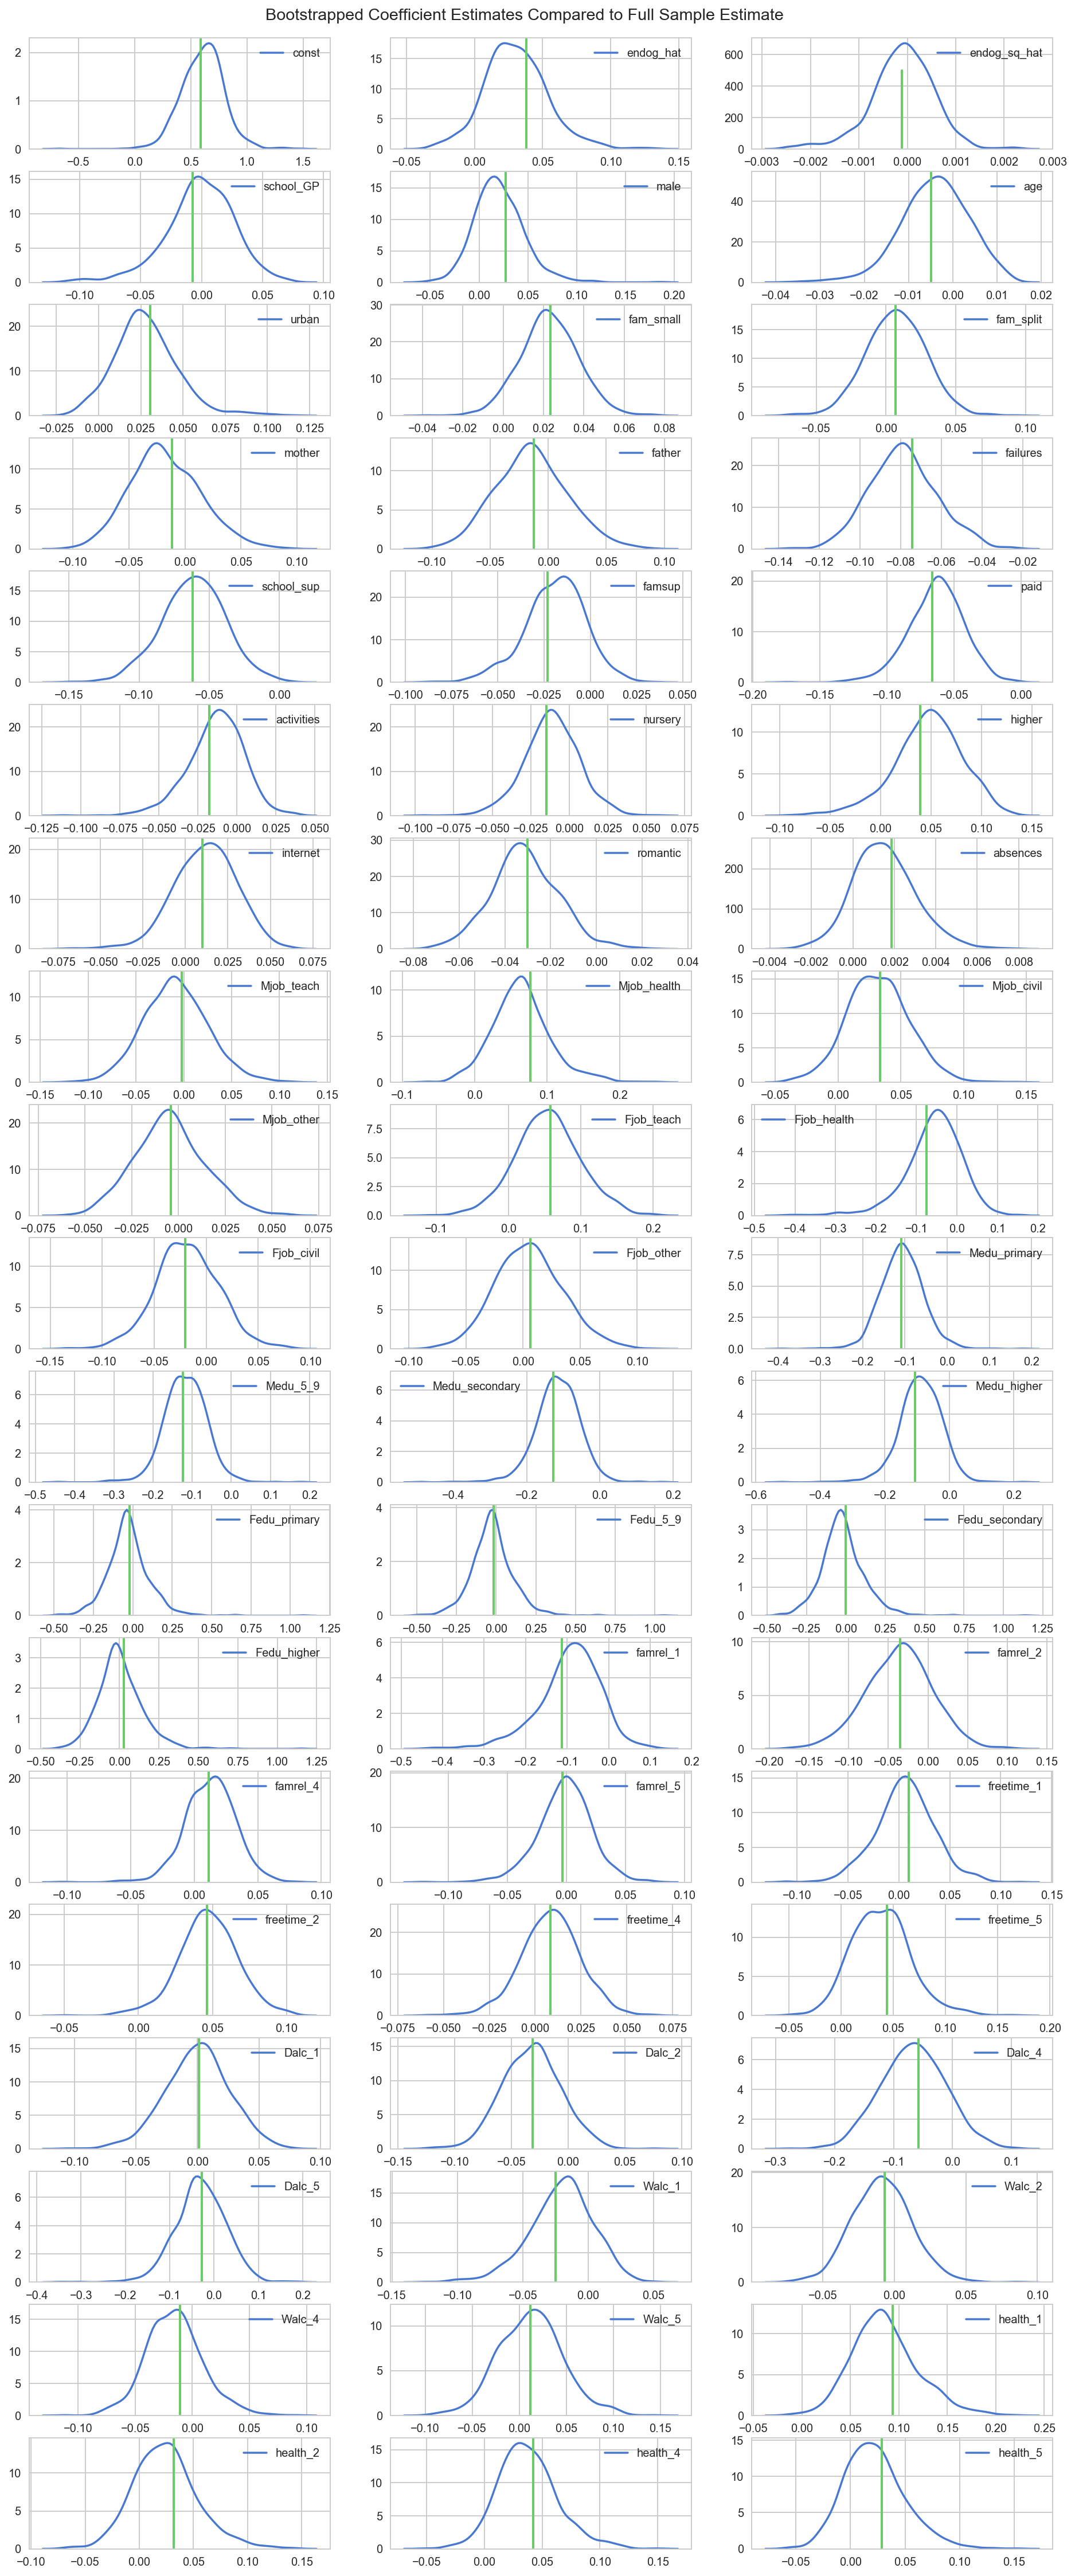

In [301]:
# Creating the plots
plt.figure(figsize=(16, 36))
sns.set(style="whitegrid", palette="muted", color_codes=True)

plt.subplots_adjust(top=0.97)
plt.suptitle('Bootstrapped Coefficient Estimates Compared to Full Sample Estimate')

sns.despine()
for column_index, column in enumerate(result_20000.X_hat.columns.values.tolist()):
    plt.subplot(19, 3, column_index + 1)
    sns.kdeplot(result_20000.beta_hat_boots[column])
    plt.plot([result_20000.result2.params[column_index], result_20000.result2.params[column_index]], 
             [0, 500], 
             linewidth=2)

# NOTE:
### At first it kind of looked like only the continuous variables were being biased, but looking closer there is also bias in the binary vars. its just that a couple of them are centered around the full sample estimates. I suppose it is possible that 20,000 is too few iterations, but that seems unlikely with a sample of 650.
### Also, see the graph below, the coeff. estimates stabalize pretty quickly

Could this be an artifact of small sample bias? It is known that 2SLS suffers from small sample bias [LINK](http://econ.lse.ac.uk/staff/spischke/ec533/Weak%20IV.pdf), but in the setting of bootstrapping, each sample is the same size, it just has repeated observations. Could this be causing bias in a funky way that's related to small sample bias? Would we expect the bias to be oddly focused on specific variables? Need to think about this more

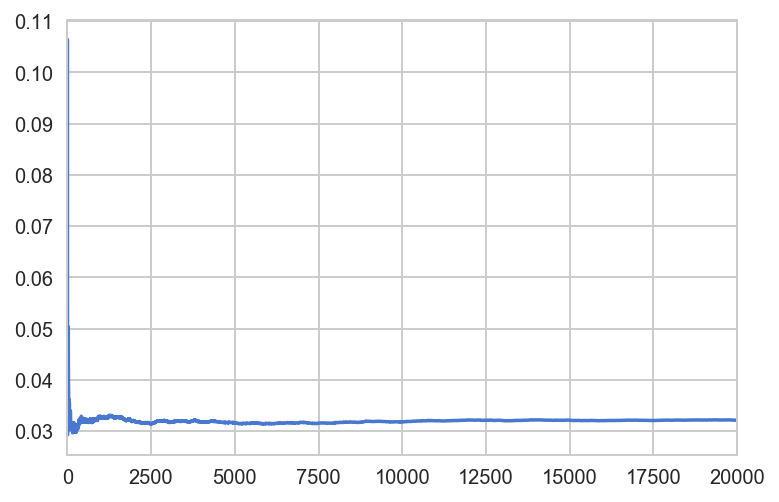

In [123]:
# Stability of coeff on endog_hat in bootstrapping
cumsum_beta_hat_boots = np.cumsum(result_20000.beta_hat_boots['endog_hat'])
sns.tsplot(cumsum_beta_hat_boots/np.arange(20000));

In [146]:
import quadratic2SLS as q2sls
import importlib
importlib.reload(q2sls)

Y = student_perf.G3_perc
X = student_perf[['school_GP', 'course_math', 'male', 'age', 'urban', 'fam_small', 'fam_split', 
                  'mother', 'father', 'failures', 'school_sup', 'famsup', 'paid', 
                  'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences',
                  'Mjob_teach', 'Mjob_health', 'Mjob_civil', 'Mjob_other', 
                  'Fjob_teach', 'Fjob_health', 'Fjob_civil', 'Fjob_other',
                  'Medu_primary', 'Medu_5_9', 'Medu_secondary', 'Medu_higher', 
                  'Fedu_primary', 'Fedu_5_9', 'Fedu_secondary', 'Fedu_higher', 
                  'famrel_1', 'famrel_2', 'famrel_4', 'famrel_5',
                  'freetime_1', 'freetime_2', 'freetime_4', 'freetime_5',
                  'Dalc_1', 'Dalc_2', 'Dalc_4', 'Dalc_5',
                  'Walc_1', 'Walc_2', 'Walc_4', 'Walc_5',
                  'health_1', 'health_2', 'health_4', 'health_5']]
X = sm.add_constant(X)
X_endog = student_perf['studytime_continuous']
student_perf['artificial_instrument'] = 1*(student_perf.reason == 'home')*1*(student_perf.traveltime > 1)
Z = student_perf[['artificial_instrument',
                  'goout_1', 'goout_2', 'goout_4', 'goout_5']]

np.random.seed(1234)
model = q2sls. Quadratic2SLS(Y, X, X_endog, Z, X, Z)
#result = model.fit(cov_type='Bootstrap', n_iter = 50000)
result = model.fit(cov_type='Bootstrap', n_iter = 1000)
coeff_estms = pd.DataFrame([result.beta_hat_boots.mean(axis=0), result.result2.params]).transpose()
coeff_estms.columns = ['Bootstrapped', 'Full_Sample']
coeff_estms


100%|██████████| 1000/1000 [00:23<00:00, 42.74it/s]


,Bootstrapped,Full_Sample
const,1.009883,1.001857
endog_hat,0.054567,0.067540
endog_sq_hat,-0.000263,-0.000436
school_GP,0.028725,0.019532
course_math,-0.160119,-0.163063
male,0.044875,0.053801
age,-0.007405,-0.009293
urban,0.046670,0.050473
fam_small,0.042015,0.043488
fam_split,0.007195,0.003929


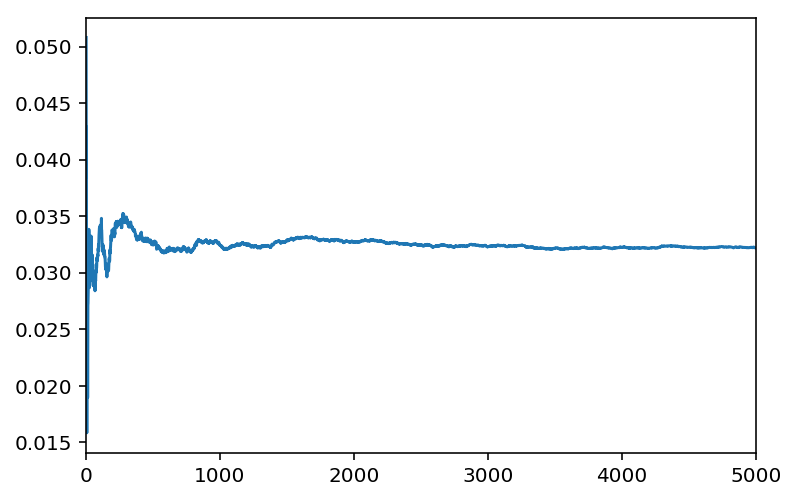

In [77]:
# Stability of coeff on endog_hat in bootstrapping
cumsum_beta_hat_boots = np.cumsum(result.beta_hat_boots['endog_hat'])
sns.tsplot(cumsum_beta_hat_boots/np.array(list(range(0, model.n_iter))));

# PROBLEM!!!
### seems like there still might be a problem with the bootstrapping estimates. the estimated coefficient in bootstrapping never gets even close to the estimated coefficient in the full sample. i already tested whether it was the order of indicies, and fixed that issue, but maybe there is a seperate problem?

In [125]:
from linearmodels.iv import IV2SLS 
model = IV2SLS(Y, X, X_endog, Z)
results = model.fit()
print(results.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                G3_perc   R-squared:                      0.2104
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1371
No. Observations:                 649   F-statistic:                    347.44
Date:                Thu, Apr 19 2018   P-value (F-stat)                0.0000
Time:                        13:30:41   Distribution:                 chi2(55)
Cov. Estimator:                robust                                         
                                                                              
                                  Parameter Estimates                                   
                      Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------
const                    0.6544     0.2529     2.5874     0.0097      0.1587      1.1500
school_GP   